In [3]:
import numpy as np
import pandas as pd 
import os
import cv2

In [4]:
labels = os.listdir("../input/drowsiness-dataset/train")

In [5]:
labels


['Closed', 'Open', 'yawn', 'no_yawn']

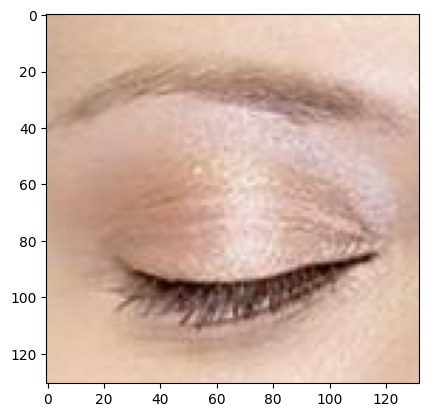

In [6]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_2.jpg"))

In [7]:
a = plt.imread("../input/drowsiness-dataset/train/Closed/_2.jpg")

In [8]:
a.shape

(131, 132, 3)

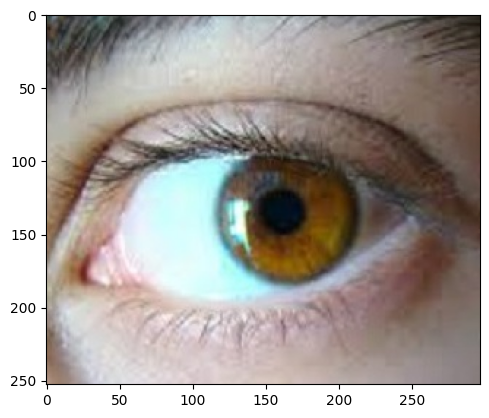

In [9]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Open/_10.jpg"))

In [10]:
def get_data(dir_path="../input/drowsiness-dataset/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [11]:
data_train = get_data()

2
3


In [12]:
new_data = data_train

In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [16]:
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [18]:
len(X_test)


291

In [19]:
len(X_train)

1161

In [20]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [21]:
#train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
#test_generator = ImageDataGenerator(rescale=1/255)

#train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
#test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation on the training set
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,  # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Create an ImageDataGenerator for rescaling on the test set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1/255)

# Create data generators for training and testing
batch_size = 32  # You can adjust this batch size
train_generator = train_datagen.flow(
    np.array(X_train), y_train, batch_size=batch_size, shuffle=True)

test_generator = test_datagen.flow(
    np.array(X_test), y_test, batch_size=batch_size, shuffle=False)


In [23]:
from tensorflow.keras.initializers import glorot_uniform

model = Sequential()

model.add(Conv2D(512, (3, 3), activation="relu", input_shape=X_train.shape[1:], kernel_initializer=glorot_uniform()))
model.add(MaxPooling2D(2, 2))

#model.add(Conv2D(512, (3, 3), activation="relu", input_shape=X_train.shape[1:]))



model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [24]:
history = model.fit(train_generator, epochs=60, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/60
37/37 [==============================] - 22s 226ms/step - loss: 26472.2832 - accuracy: 0.2239 - val_loss: 224763.4375 - val_accuracy: 1.0000
Epoch 2/60
37/37 [==============================] - 7s 194ms/step - loss: 174492016.0000 - accuracy: 0.2231 - val_loss: 1047784192.0000 - val_accuracy: 0.0000e+00
Epoch 3/60
37/37 [==============================] - 8s 210ms/step - loss: 40123629568.0000 - accuracy: 0.2558 - val_loss: 158661705728.0000 - val_accuracy: 0.0000e+00
Epoch 4/60
37/37 [==============================] - 7s 193ms/step - loss: 1427951058944.0000 - accuracy: 0.2558 - val_loss: 4260023238656.0000 - val_accuracy: 0.0000e+00
Epoch 5/60
37/37 [==============================] - 7s 194ms/step - loss: 23483337670656.0000 - accuracy: 0.2205 - val_loss: 121520630267904.0000 - val_accuracy: 1.0000
Epoch 6/60
37/37 [==============================] - 7s 192ms/step - loss: 426999810097152.0000 - accuracy: 0.2558 - val_loss: 691158082650112.0000 - val_accuracy: 0.0000e+00
Epoch

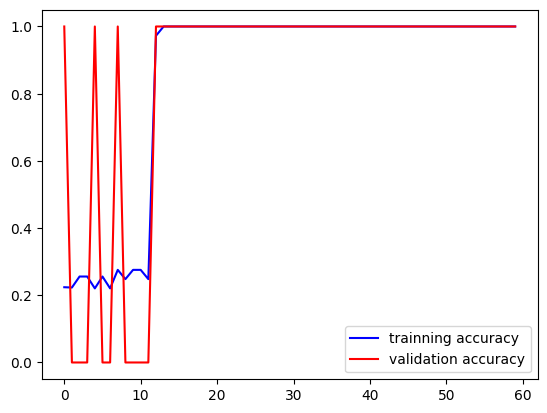

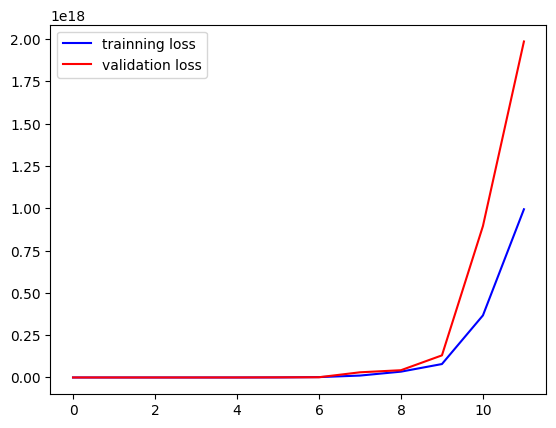

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [26]:
model.save("drowiness_new1.h5")

In [27]:
model.save("drowiness_new1.model")

In [28]:
from tensorflow.keras.models import load_model

model = load_model('drowiness_new1.h5')


In [29]:
import numpy as np

# Assuming model is your trained Sequential model
y_probabilities = model.predict(X_test)
y_pred = np.argmax(y_probabilities, axis=1)

# y_pred now contains the predicted class labels

#prediction = model.predict_classes(X_test)
#y_prob = model.predict(X_test)
#y_pred = (y_prob > 0.5).astype(int)  # Adjust the threshold as needed

# y_pred will contain the binary class labels (0 or 1)


10/10 [==============================] - 0s 28ms/step


In [30]:
y_probabilities
#prediction

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)

In [31]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [32]:
labels_new = ["Closed", "Open"]

In [33]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels_new))

ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
labels_new = ["Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new1.h5")

In [ ]:
#0-yawn, 1-no_yawn, 2-Closed, 3-Open
y_pred= model.predict([prepare("../input/drowsiness-dataset/train/no_yawn/1067.jpg")])
np.argmax(y_pred)

In [ ]:
y_pred = model.predict([prepare("../input/drowsiness-dataset/train/Closed/_101.jpg")])
np.argmax(y_pred)

In [ ]:
y_pred= model.predict([prepare("../input/drowsiness-dataset/train/Open/_104.jpg")])
np.argmax(y_pred)

In [ ]:
y_pred = model.predict([prepare("../input/drowsiness-dataset/train/yawn/113.jpg")])
np.argmax(y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, X, y):
    # Make predictions using the model
    y_pred = model.predict(X)

    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Calculate ROC-AUC score (if your model outputs probabilities)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]  # Assuming binary classification
        roc_auc = roc_auc_score(y, y_probabilities)
    else:
        roc_auc = None

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Create a dictionary to store the results
    evaluation_results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "True Positives": tp,
        "True Negatives": tn,
        "False Positives": fp,
        "False Negatives": fn,
    }
    

    return evaluation_results
evaluation_results = evaluate_model(model, X, y)
print("Evaluation Results:")
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

# Example usage:
# Replace 'model', 'X', and 'y' with your actual model and data
# evaluation_results = evaluate_model(model, X, y)
# print(evaluation_results)


In [ ]:
#evaluation_results

In [ ]:
#!pip install tensorflow==2.3.1
#!pip install keras==2.4.3

In [ ]:
#tf.__version__

In [ ]:
# import keras
#keras.__version__